# MOEA/D Searcher example

This is an example about how using MOEADSearcher for multi-objectives optimization.

## 1. Import modules and prepare data

In [1]:
from hypernets.core.random_state import set_random_state
set_random_state(1234)

from hypernets.utils import logging as hyn_logging
from hypernets.examples.plain_model import PlainModel, PlainSearchSpace
from hypernets.searchers.nsga_searcher import RNSGAIISearcher

from hypergbm import make_experiment

from hypernets.tabular import get_tool_box
from hypernets.tabular.datasets import dsutils
from hypernets.tabular.sklearn_ex import MultiLabelEncoder


hyn_logging.set_level(hyn_logging.WARN)

df = dsutils.load_bank().head(1000)
tb = get_tool_box(df)
df_train, df_test = tb.train_test_split(df, test_size=0.2, random_state=9527)

D:\miniconda3\envs\hypergbm-dev\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Run an experiment within NSGAIISearcher

In [2]:
experiment = make_experiment(df_train,
                             eval_data=df_test.copy(),
                             callbacks=[],
                             random_state=1234,
                             search_callbacks=[],
                             target='y',
                             searcher='moead',  # available MOO searcher: moead, nsga2, rnsga2
                             reward_metric='logloss',
                             objectives=['nf'],
                             drift_detection=False,
                             early_stopping_rounds=30)

estimators = experiment.run(max_trials=30)
hyper_model = experiment.hyper_model_
hyper_model.searcher

MOEADSearcher(objectives=[PredictionObjective(name=logloss, scorer=make_scorer(log_loss, needs_proba=True), direction=min), NumOfFeatures(name=nf, sample_size=2000, direction=min)], n_neighbors=2, recombination=SinglePointCrossOver(random_state=RandomState(MT19937)), mutation=SinglePointMutation(random_state=RandomState(MT19937), proba=0.3), population_size=6)

## 3. Summary trails

In [3]:
df_trials = hyper_model.history.to_df().copy().drop(['scores', 'reward'], axis=1)
df_trials[df_trials['non_dominated'] == True]

,trial_no,succeeded,elapsed,non_dominated,model_index,reward_logloss,reward_nf
4,5,True,0.267513,True,0.0,0.335822,0.5
6,7,True,1.861280,True,1.0,0.561268,0.0
8,9,True,2.050606,True,2.0,0.344421,0.0625
19,24,True,0.930639,True,3.0,0.318113,0.8125
22,30,True,0.268542,True,4.0,0.325241,0.75


## 4. Plot pareto font

We can pick model accord to Decision Maker's preferences from the pareto plot, the number in the figure indicates the index of pipeline models.


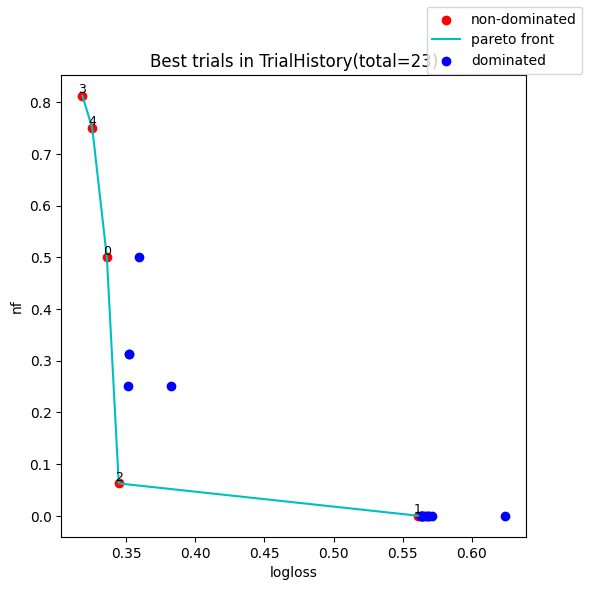

In [4]:
fig, ax  = hyper_model.history.plot_best_trials()
fig.show()

## 5. Plot population

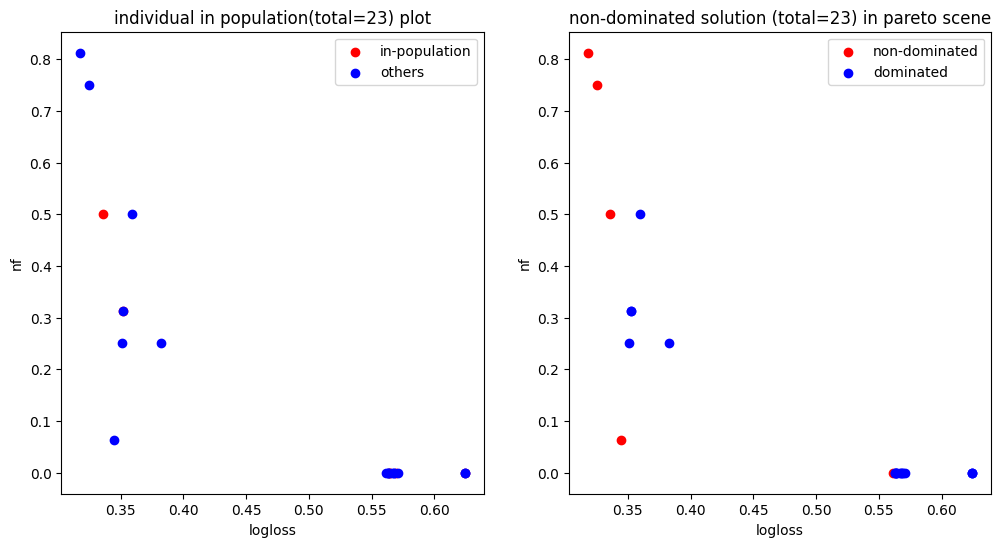

In [5]:
fig, ax  = hyper_model.searcher.plot_population()
fig.show()

## 6. Evaluate the selected model

In [6]:
print(f"Number of pipeline: {len(estimators)} ")

pipeline_model = estimators[0]  # selection the first pipeline model
X_test = df_test.copy()
y_test = X_test.pop('y')

preds = pipeline_model.predict(X_test)
proba = pipeline_model.predict_proba(X_test)

tb.metrics.calc_score(y_test, preds, proba, metrics=['auc', 'accuracy', 'f1', 'recall', 'precision'], pos_label="yes")

Number of pipeline: 5 


{'auc': 0.8417038690476191,
 'accuracy': 0.855,
 'f1': 0.17142857142857143,
 'recall': 0.09375,
 'precision': 1.0}

## Automatically convert metric to negatives for minimize

In [8]:
experiment = make_experiment(df_train,
                             eval_data=df_test.copy(),
                             callbacks=[],
                             random_state=1234,
                             search_callbacks=[],
                             target='y',
                             pos_label="yes",
                             searcher='moead',
                             reward_metric='accuracy',
                             objectives=['precision'],
                             drift_detection=False,
                             early_stopping_rounds=30)

estimators = experiment.run(max_trials=30)
hyper_model = experiment.hyper_model_
hyper_model.history.to_df().copy().drop(['scores', 'reward'], axis=1)[:5]

,trial_no,succeeded,elapsed,non_dominated,model_index,reward_accuracy,reward_precision
0,1,True,0.379063,False,NaN,-0.84,-0.5
1,2,True,0.431345,False,NaN,-0.84,-0.0
2,3,True,0.445994,False,NaN,-0.84,-0.0
3,4,True,0.449042,True,0.0,-0.86,-1.0
4,5,True,0.314518,False,NaN,-0.855,-1.0
